# ChestXNet: Pneumonia Detection on Chest X-rays with Convolutional Neural Networks

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

from glob import glob
from itertools import chain
from random import sample
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix, average_precision_score, accuracy_score

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.applications.densenet import DenseNet121

%matplotlib inline

Using TensorFlow backend.


## Processing of the metadata:

In [11]:
# Loading the NIH data into dataframe together with full image filepaths for easier manipulation

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
54663,00013670_170.png,Infiltration,170,13670,56,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00013670_170.png
19647,00005218_020.png,Nodule,20,5218,38,M,AP,2048,2500,0.171,0.171,NaN,/data/images_003/images/00005218_020.png
68795,00016974_001.png,Atelectasis|Mass,1,16974,14,F,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00016974_001.png


In [12]:
# Splitting the "Finding Labels" columns to have a binary column for each disease
disease_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))

for label in disease_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda x: 1.0 if label in x else 0)

# Creating  a new column called 'pneumonia_class' for binary classification
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})

# Moving the index to a separate column 'Scan_ID' for later manipulation during train/validation/test splits
all_xray_df['Scan_ID'] = all_xray_df.index
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Scan_ID
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,1
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,3
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,4


## Creating training, validation and test datasets:

Goals:
- no patient overlap between the datasets
- balanced training and validation datasets 
- imbalanced test set with 20% of positive pneumonia cases

In [25]:
# Splitting the data into two portions:
# 1) 80% training and validation datasets
# 2) 20% test dataset
# in such a way that there is no Patient ID overlap between the sets
train_valid_inds, test_inds = next(GroupShuffleSplit(test_size=0.2, 
                                                     n_splits=1, 
                                                     random_state = 16).split(all_xray_df, groups=all_xray_df['Patient ID']))

train_valid_df = all_xray_df.loc[train_valid_inds]
test_df = all_xray_df.loc[test_inds]

# Resetting index for further split
train_valid_df.reset_index(inplace=True)
train_valid_df.head()

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Scan_ID
0,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,3
1,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,4
2,5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,5
3,6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,6
4,7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,7


In [26]:
# Splitting the train_valid dataset into two portions:
# 1) 90% training dataset
# 2) 10% validation dataset
# in such a way that there is no Patient ID overlap between the sets
train_inds, valid_inds = next(GroupShuffleSplit(test_size=0.1, 
                                                n_splits=1, 
                                                random_state = 16).split(train_valid_df, groups=train_valid_df['Patient ID']))

train_df = train_valid_df.loc[train_inds]
valid_df = train_valid_df.loc[valid_inds] 

In [27]:
# Confirming that there is no Scan_ID overlap between the datasets
train_scan_ids = train_df['Scan_ID'].to_numpy()
valid_scan_ids = valid_df['Scan_ID'].to_numpy()
test_scan_ids = test_df['Scan_ID'].to_numpy()
print(f'Scan ID overlap between train and valid datasets: {np.intersect1d(train_scan_ids, valid_scan_ids)}') 
print(f'Scan ID overlap between train and test datasets: {np.intersect1d(train_scan_ids, valid_scan_ids)}') 
print(f'Scan ID overlap between valid and test datasets: {np.intersect1d(valid_scan_ids, test_scan_ids)}') 

Scan ID overlap between train and valid datasets: []
Scan ID overlap between train and test datasets: []
Scan ID overlap between valid and test datasets: []


In [28]:
# Confirming that there is no Patient_ID overlap between the datasets
train_patient_ids = train_df['Patient ID'].to_numpy()
valid_patient_ids = valid_df['Patient ID'].to_numpy()
test_patient_ids = test_df['Patient ID'].to_numpy()
print(f'Patient ID overlap between train and valid datasets: {np.intersect1d(np.unique(train_patient_ids), np.unique(valid_patient_ids))}') 
print(f'Patient ID overlap between train and test datasets: {np.intersect1d(np.unique(train_patient_ids), np.unique(test_patient_ids))}')
print(f'Patient ID overlap between valid and test datasets: {np.intersect1d(np.unique(valid_patient_ids), np.unique(test_patient_ids))}')

Patient ID overlap between train and valid datasets: []
Patient ID overlap between train and test datasets: []
Patient ID overlap between valid and test datasets: []


In [29]:
# Checking how much pneumonia cases are there in the training and in the validation datasets
train_df_pneumonia_cases = len(train_df[train_df.Pneumonia==1])
valid_df_pneumonia_cases = len(valid_df[valid_df.Pneumonia==1])
test_df_pneumonia_cases = len(test_df[test_df.Pneumonia==1])
print(f'Pneumonia cases in the training set: {train_df_pneumonia_cases}.')
print(f'Pneumonia cases in the validation set: {valid_df_pneumonia_cases}.')
print(f'Pneumonia cases in the test set: {test_df_pneumonia_cases}.')
print(f'Percentage of pneumonia cases, which were assigned to the training set: {train_df_pneumonia_cases/(train_df_pneumonia_cases + valid_df_pneumonia_cases + test_df_pneumonia_cases)*100:.3}%')
print(f'Percentage of pneumonia cases, which were assigned to the validation set: {valid_df_pneumonia_cases/(train_df_pneumonia_cases + valid_df_pneumonia_cases + test_df_pneumonia_cases)*100:.3}%')
print(f'Percentage of pneumonia cases, which were assigned to the test set: {test_df_pneumonia_cases/(train_df_pneumonia_cases + valid_df_pneumonia_cases + test_df_pneumonia_cases)*100:.3}%')

Pneumonia cases in the training set: 1070.
Pneumonia cases in the validation set: 87.
Pneumonia cases in the test set: 274.
Percentage of pneumonia cases, which were assigned to the training set: 74.8%
Percentage of pneumonia cases, which were assigned to the validation set: 6.08%
Percentage of pneumonia cases, which were assigned to the test set: 19.1%


In [36]:
# Sampling randomly negative cases, such that the traning dataset consist of 50% positive cases.
train_scan_ids_pos = train_df[train_df.Pneumonia==1].index.to_numpy()
train_scan_ids_neg = train_df[train_df.Pneumonia==0].index.to_numpy()
train_scan_ids_neg_sample = np.random.choice(train_scan_ids_neg, size=train_df_pneumonia_cases, replace=False)
train_scan_ids_pos_neg_sample = np.concatenate((train_scan_ids_pos, train_scan_ids_neg_sample))
train_df = train_df.loc[train_scan_ids_pos_neg_sample]
train_df = train_df.sample(frac=1)
train_df.head()

,index,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,Scan_ID
4310,5390,00001437_024.png,Consolidation|Effusion|Infiltration|Pneumonia,24,1437,30,F,PA,2386,2497,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive,5390
74392,92896,00023178_003.png,Atelectasis,3,23178,58,F,PA,2992,2991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,92896
36595,45938,00011760_003.png,No Finding,3,11760,35,F,AP,2500,2048,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Negative,45938
44934,56057,00013993_113.png,Atelectasis|Effusion,113,13993,43,M,AP,2500,2048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative,56057
87948,109877,00029889_000.png,Pneumonia,0,29889,44,F,PA,2021,2021,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive,109877


In [37]:
# Sampling randomly negative cases, such that the validation dataset consist of 50% positive cases.
valid_scan_ids_pos = valid_df[valid_df.Pneumonia==1].index.to_numpy()
valid_scan_ids_neg = valid_df[valid_df.Pneumonia==0].index.to_numpy()
valid_scan_ids_neg_sample = np.random.choice(valid_scan_ids_neg, size=valid_df_pneumonia_cases, replace=False)
valid_scan_ids_pos_neg_sample = np.concatenate((valid_scan_ids_pos, valid_scan_ids_neg_sample))
valid_df = valid_df.loc[valid_scan_ids_pos_neg_sample]
valid_df = valid_df.sample(frac=1)

In [38]:
# Sampling randomly negative cases, such that the test dataset consist of 20% positive cases.
test_scan_ids_pos = test_df[test_df.Pneumonia==1].index.to_numpy()
test_scan_ids_neg = test_df[test_df.Pneumonia==0].index.to_numpy()
test_scan_ids_neg_sample = np.random.choice(test_scan_ids_neg, size=4*test_df_pneumonia_cases, replace=False)
test_scan_ids_pos_neg_sample = np.concatenate((test_scan_ids_pos, test_scan_ids_neg_sample))
test_df = test_df.loc[test_scan_ids_pos_neg_sample]
test_df = test_df.sample(frac=1)

In [39]:
# Determination of the number of scans in each dataset
print(f'Number of scans in the training set: {len(train_df)}.')
print(f'Number of scans in the validation set: {len(valid_df)}.')
print(f'Number of scans in the test set: {len(test_df)}.')

Number of scans in the training set: 2140.
Number of scans in the validation set: 174.
Number of scans in the test set: 1370.


## Comparison of demographic distributions in the training, validation and test datasets:

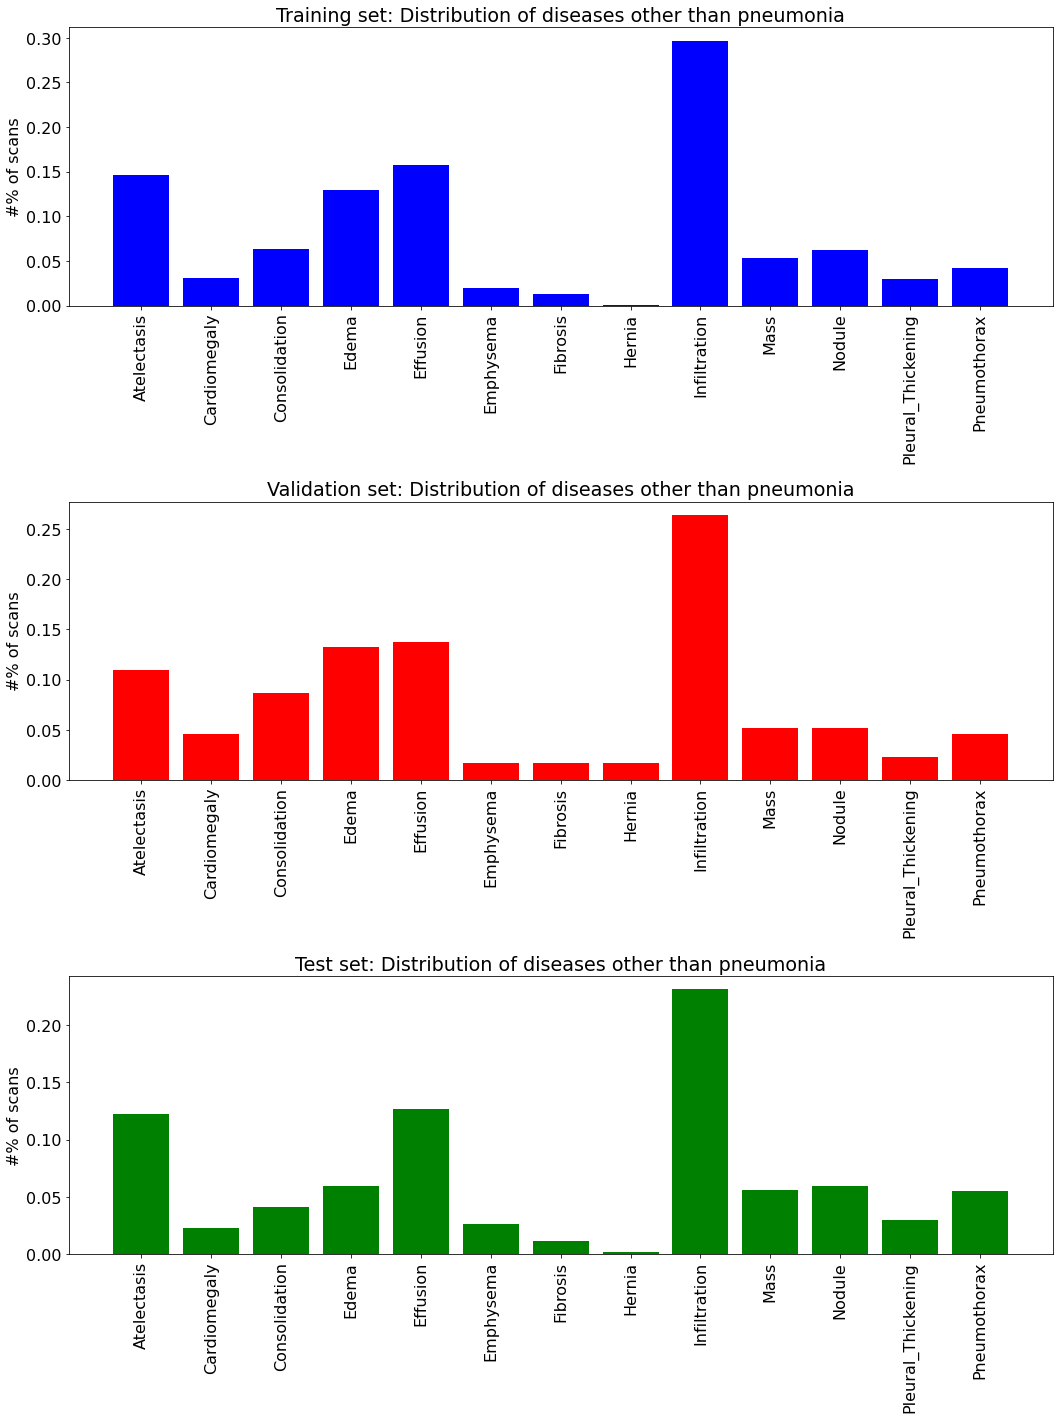

In [40]:
# Distribution of diseases other than pneumonia that are present in the scans

disease_labels_no_pneumonia = np.delete(disease_labels, [10,13]) 
    #deleting "no finding" and "pneumonia" label
    
disease_labels_no_pneumonia_occurance_train = train_df.loc[:,disease_labels_no_pneumonia].sum()/len(train_df.loc[:,disease_labels_no_pneumonia])
disease_labels_no_pneumonia_occurance_valid = valid_df.loc[:,disease_labels_no_pneumonia].sum()/len(valid_df.loc[:,disease_labels_no_pneumonia])
disease_labels_no_pneumonia_occurance_test = test_df.loc[:,disease_labels_no_pneumonia].sum()/len(test_df.loc[:,disease_labels_no_pneumonia])

fig, ax = plt.subplots(3,1, figsize=(15,20))
plt.rcParams.update({'font.size': 16})
ax[0].bar(disease_labels_no_pneumonia, disease_labels_no_pneumonia_occurance_train, color='blue')
ax[0].set_title("Training set: Distribution of diseases other than pneumonia")
ax[0].set_ylabel('#% of scans')
ax[0].set_xticklabels(disease_labels_no_pneumonia, rotation=90)

ax[1].bar(disease_labels_no_pneumonia, disease_labels_no_pneumonia_occurance_valid, color='red')
ax[1].set_title("Validation set: Distribution of diseases other than pneumonia")
ax[1].set_ylabel('#% of scans')
ax[1].set_xticklabels(disease_labels_no_pneumonia, rotation=90)

ax[2].bar(disease_labels_no_pneumonia, disease_labels_no_pneumonia_occurance_test, color='green')
ax[2].set_title("Test set: Distribution of diseases other than pneumonia")
ax[2].set_ylabel('#% of scans')
ax[2].set_xticklabels(disease_labels_no_pneumonia, rotation=90)
fig.tight_layout()

- The biggest difference is in the occurance of Edema and Hernia. Their coocurence with pheumonia will be investiaged in the next step.

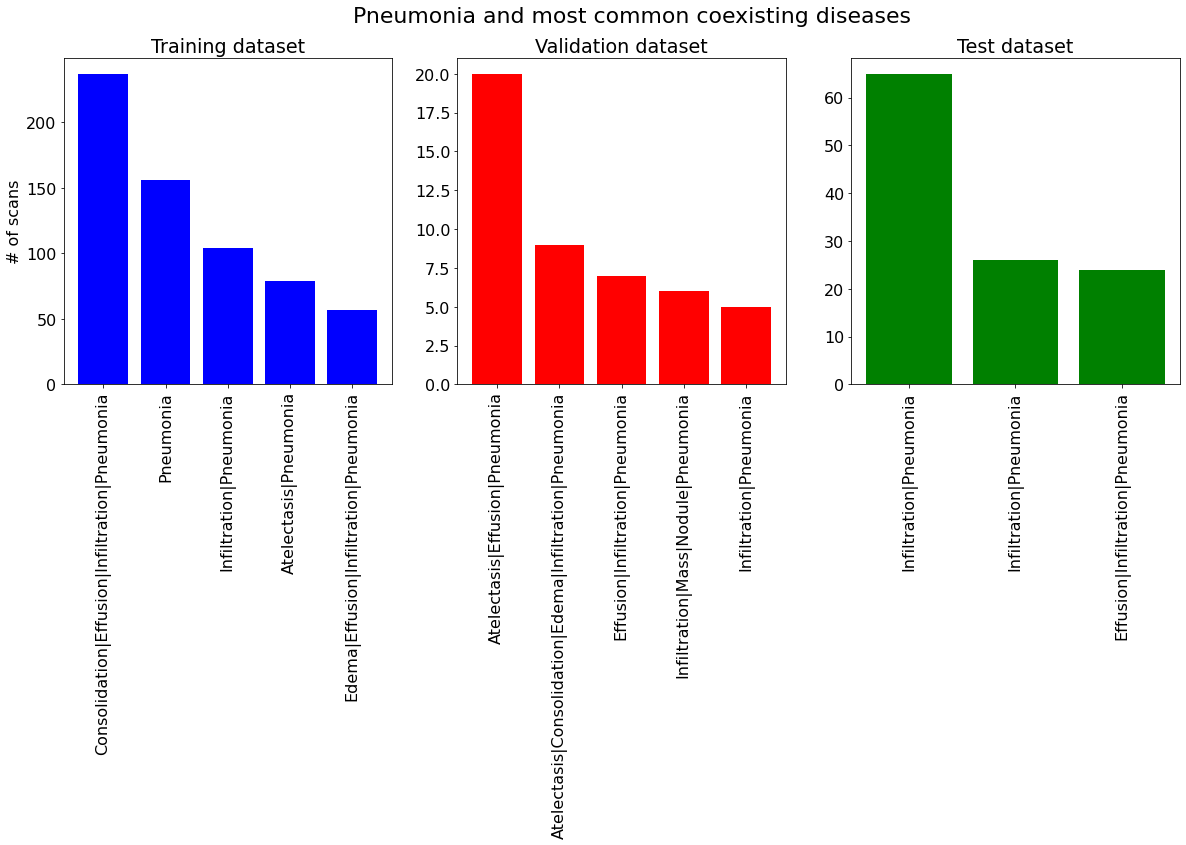

In [41]:
# Distribution of co-ocurrent diseases together with pneumonia

fig, ax = plt.subplots(1,3, figsize=(20,6))
fig.suptitle("Pneumonia and most common coexisting diseases", fontsize=22, y = 1, x = 0.52)
plt.rcParams.update({'font.size': 16})

ax[0].bar(train_df[train_df.Pneumonia==1]['Finding Labels'][0:5], 
          train_df[train_df.Pneumonia==1]['Finding Labels'].value_counts()[0:5], color='blue')
ax[0].set_title("Training dataset")
ax[0].set_xticklabels(train_df[train_df.Pneumonia==1]['Finding Labels'][0:5], rotation=90)
ax[0].set_ylabel('# of scans')

ax[1].bar(valid_df[valid_df.Pneumonia==1]['Finding Labels'][0:5], 
          valid_df[valid_df.Pneumonia==1]['Finding Labels'].value_counts()[0:5], color='red')
ax[1].set_title("Validation dataset")
ax[1].set_xticklabels(valid_df[valid_df.Pneumonia==1]['Finding Labels'][0:5], rotation=90)

ax[2].bar(test_df[test_df.Pneumonia==1]['Finding Labels'][0:5], 
          test_df[test_df.Pneumonia==1]['Finding Labels'].value_counts()[0:5], color='green')
ax[2].set_title("Test dataset")
ax[2].set_xticklabels(test_df[test_df.Pneumonia==1]['Finding Labels'][0:5], rotation=90)

plt.show()

Coocurent diseases:
- In all datasets Pneumonia most frequently is present in a scan together with other diseases, whose combination varies between datasets.

Coocurence with Edema and Hernia:
- In the training dataset, the 5th most common coocurence with Pneumonia is Edema together with Effusion and Inflitration.
- In the validation dataset, the 2nd most common coocurence with Pneumonia is Edema together with Atelectasis, Consolidation and Infiltration.
- Hernia is not one of the most common coocurances with Pneumonia.

<br>
During in-depth evaluation of the best model, possible cross-talk existance between pneumonia and the most common coocurent diseses has to be investigated.

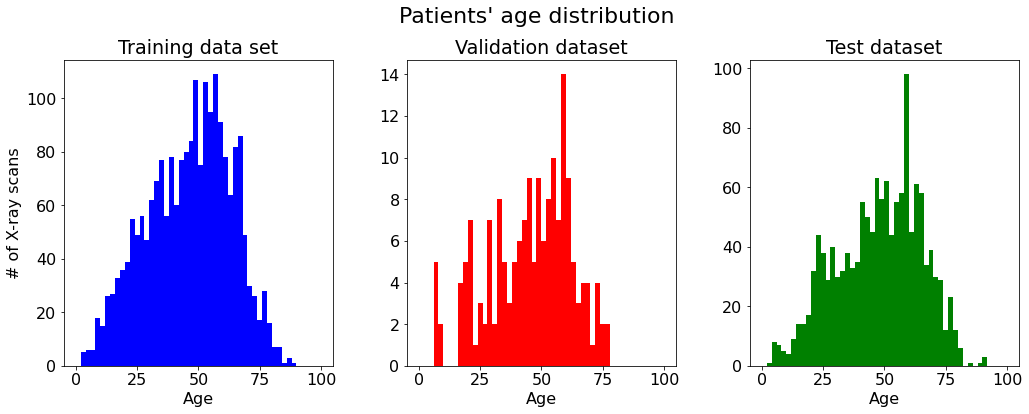

In [42]:
# Distribution of age 

fig, ax = plt.subplots(1,3, figsize=(15,6))
fig.suptitle("Patients' age distribution", fontsize=22, y = 1, x = 0.52)

plt.rcParams.update({'font.size': 16})
ax[0].hist(train_df['Patient Age'], bins=50, range=(0,100), color='blue')
ax[0].set_title("Training data set")
ax[0].set_xlabel('Age')
ax[0].set_ylabel('# of X-ray scans')
ax[1].hist(valid_df['Patient Age'], bins=50, range=(0,100), color='red')
ax[1].set_title("Validation dataset")
ax[1].set_xlabel('Age')
ax[2].hist(test_df['Patient Age'], bins=50, range=(0,100), color='green')
ax[2].set_title("Test dataset")
ax[2].set_xlabel('Age')
fig.tight_layout(pad=2.0)
plt.show()

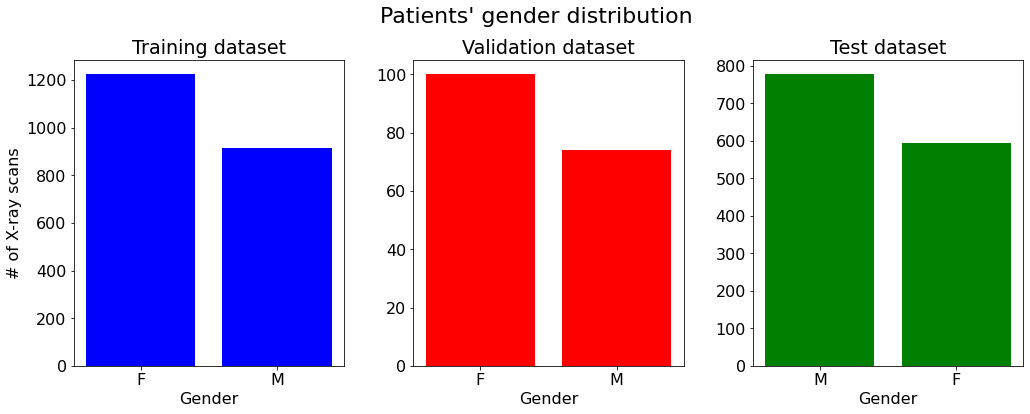

In [43]:
# Distribution of patients' gender 

fig, ax = plt.subplots(1,3, figsize=(15,6))
fig.suptitle("Patients' gender distribution", fontsize=22, y = 1, x = 0.52)
plt.rcParams.update({'font.size': 16})

ax[0].bar(train_df['Patient Gender'].unique(),train_df['Patient Gender'].value_counts(), color='blue')
ax[0].set_title("Training dataset")
ax[0].set_xlabel('Gender')
ax[0].set_ylabel('# of X-ray scans')

ax[1].bar(valid_df['Patient Gender'].unique(), valid_df['Patient Gender'].value_counts(), color='red')
ax[1].set_title("Validation dataset")
ax[1].set_xlabel('Gender')

ax[2].bar(test_df['Patient Gender'].unique(), test_df['Patient Gender'].value_counts(), color='green')
ax[2].set_title("Test dataset")
ax[2].set_xlabel('Gender')

fig.tight_layout(pad=2.0)
plt.show()

In [44]:
M_F_ratio_train = train_df['Patient Gender'].value_counts()[0] / train_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: Training dataset {M_F_ratio_train:.2}.')

M_F_ratio_valid = valid_df['Patient Gender'].value_counts()[0] / valid_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: Validation dataset {M_F_ratio_valid:.2}.')

M_F_ratio_test = test_df['Patient Gender'].value_counts()[0] / test_df['Patient Gender'].value_counts()[1] 
print(f'M/F ratio: Test dataset {M_F_ratio_test:.2}.')

M/F ratio: Training dataset 1.3.
M/F ratio: Validation dataset 1.4.
M/F ratio: Test dataset 1.3.


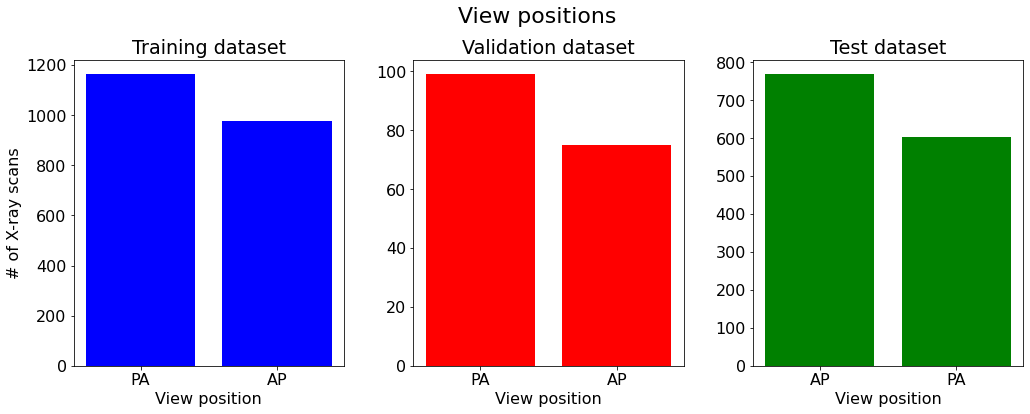

In [45]:
# Distribution of view position in the train and the validaton set
fig, ax = plt.subplots(1,3, figsize=(15,6))
fig.suptitle("View positions", fontsize=22, y = 1, x = 0.52)
plt.rcParams.update({'font.size': 16})

ax[0].bar(train_df['View Position'].unique(),train_df['View Position'].value_counts(), color='blue')
ax[0].set_title("Training dataset")
ax[0].set_xlabel('View position')
ax[0].set_ylabel('# of X-ray scans')

ax[1].bar(valid_df['View Position'].unique(), valid_df['View Position'].value_counts(), color='red')
ax[1].set_title("Validation dataset")
ax[1].set_xlabel('View position')

ax[2].bar(test_df['View Position'].unique(), test_df['View Position'].value_counts(), color='green')
ax[2].set_title("Test dataset")
ax[2].set_xlabel('View position')

fig.tight_layout(pad=2.0)
plt.show()

In [46]:
PA_AP_ratio_train = train_df['View Position'].value_counts()[0] / train_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: Training dataset {PA_AP_ratio_train:.2}.')

PA_AP_ratio_valid = valid_df['View Position'].value_counts()[0] / valid_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: Validation dataset {PA_AP_ratio_valid:.2}.')

PA_AP_ratio_test = test_df['View Position'].value_counts()[0] / test_df['View Position'].value_counts()[1] 
print(f'PA/AP ratio: Test dataset {PA_AP_ratio_test:.2}.')

PA/AP ratio: Training dataset 1.2.
PA/AP ratio: Validation dataset 1.3.
PA/AP ratio: Test dataset 1.3.


PA projection:
- patient is standing: X-ray beam passes through the patient from Posterior to Anterior (i.e. from back to front)

AP projection:
- patient is sitting: X-ray beam passes through the patient from Anterior to Posterior (i.e. from front to back)

<br>
Differences between PA and AP views:
- heart size is exaggerated in the AP projection, as it is realtively further from the detector and and the X-ray beam is more divergent.
- AP projection images are of lower quality then PA images.

Ref: https://www.radiologymasterclass.co.uk/tutorials/chest/chest_quality/chest_xray_quality_projection


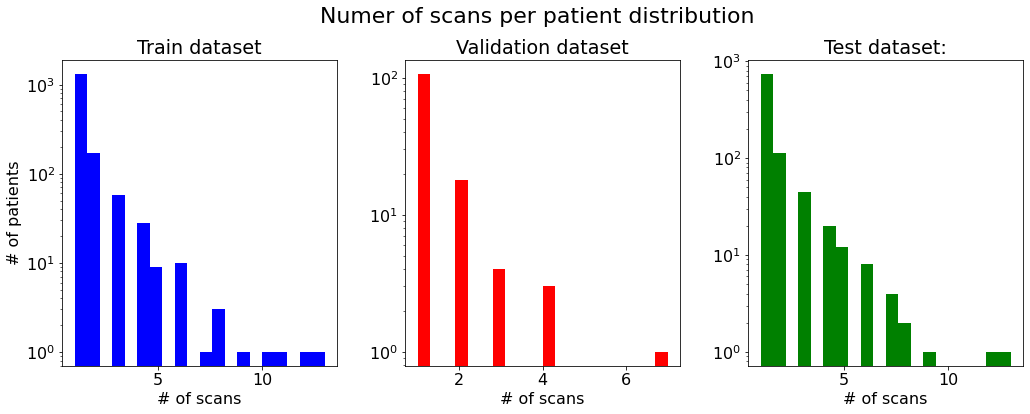

In [47]:
# Distribution of number of scans per patient in the train and the validaton set
fig, ax = plt.subplots(1,3, figsize=(15,6))
fig.suptitle("Numer of scans per patient distribution", fontsize=22, y = 1, x = 0.52)
plt.rcParams.update({'font.size': 16})

ax[0].hist(train_df['Patient ID'].value_counts(), bins=20, log=True, color='blue')
ax[0].set_title("Train dataset")
ax[0].set_xlabel('# of scans')
ax[0].set_ylabel('# of patients')

ax[1].hist(valid_df['Patient ID'].value_counts(), bins=20, log=True, color='red')
ax[1].set_title("Validation dataset")
ax[1].set_xlabel('# of scans')

ax[2].hist(test_df['Patient ID'].value_counts(), bins=20, log=True, color='green')
ax[2].set_title("Test dataset:")
ax[2].set_xlabel('# of scans')

fig.tight_layout(pad=2.0)
plt.show()

## Saving and loading of training, validation and test datasets:

In [48]:
# Saving train_df, valid_df and test_df
train_df.to_pickle('train_df.pkl')
valid_df.to_pickle('valid_df.pkl')
test_df.to_pickle('test_df.pkl')

In [49]:
# Loading train_df, valid_df and test_df
train_df = pd.read_pickle('train_df.pkl')
valid_df = pd.read_pickle('valid_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

## Functions for training, validation and test generators

In [4]:
def image_generator_train(samplewise_center=True, samplewise_std_normalization=True, 
                             height_shift_range=0.1, width_shift_range=0.1, 
                             rotation_range=2, zoom_range=0.01):
    
    """
    Return training image data generator with augumented images
    
    Args:
    samplewise_center (Boolean): Set each sample mean to 0.
    samplewise_std_normalization (Boolean): Divide each input by its std.
    height_shift_range (Float): Fraction of total height.
    width_shift_range (Float): Fraction of total width.
    rotation_range (Int): Degree range for random rotations.
    zoom_range (Float or [lower, upper]): Range for random zoom.
    
    Returns:
        train_idg (ImageDataGenrator): image generator for training set
    """
    
    train_idg = ImageDataGenerator(samplewise_center = samplewise_center,
                                   samplewise_std_normalization = samplewise_std_normalization,
                                   height_shift_range = height_shift_range,
                                   width_shift_range = width_shift_range,
                                   rotation_range = rotation_range,
                                   zoom_range = zoom_range)
    
    return train_idg



def get_generator_train(train_idg, train_df, directory=None, x_col='path', y_col='pneumonia_class', 
                  class_mode='binary', target_size=(224, 224), batch_size=64, shuffle=True, seed=16):
    
    """
    Return generator for the training set, reading the image paths to load from dataframe
    
    Args:
      train_idg (ImageDataGenerator) image data generator for the training set.
      train_df (dataframe): dataframe containing training data.
      directory (str): directory, in which image files are held.
      x_col (str): name of column in dataframe that holds filenames.
      y_col (str): name of column in dataframe that holds filenames the label for images.
      class_mode (str): one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. 
      target_size (tuple of integers (height, width)): default: The dimensions to which all images found will be resized.
      batch_size (int): images per batch to be fed into model during training.
      shuffle (Boolean): whether to shuffle the data 
      seed (int): random seed.
    
    Returns:
        train_gen (DataFrameIterator): iterator over training set
    """
    
    train_gen = train_idg.flow_from_dataframe(dataframe = train_df, 
                                         directory=directory,
                                         x_col = x_col,
                                         y_col = y_col,   
                                         class_mode = class_mode,
                                         target_size = target_size,
                                         shuffle = shuffle,
                                         seed = seed,
                                         batch_size = batch_size)     

    return train_gen

In [5]:
def get_test_valid_generator(samplewise_center=True, samplewise_std_normalization=True, train_df=train_df, valid_df=valid_df,
                             test_df=test_df, directory=None, x_col='path', y_col='pneumonia_class', class_mode='binary', 
                             target_size=(224, 224), sample_size = 100, batch_size=64, shuffle=True, seed=16):
    
    """
    Return generator for validation set and test test set using 
    statistics from training set.

    Args:
        samplewise_center (Boolean): Set each sample mean to 0.
        samplewise_std_normalization (Boolean): Divide each input by its std.
        train_df (dataframe): dataframe containing training data.
        valid_df (dataframe): dataframe containing validation data.
        test_df (dataframe): dataframe containing test data.
        directory (str): directory, in which image files are held.
        x_col (str): name of column in dataframe that holds filenames.
        y_col (str): name of column in dataframe that holds filenames the label for images.
        class_mode (str): one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. 
        target_size (tuple of integers (height, width)): default: The dimensions to which all images found will be resized.
        sample_size (int): size of sample to use for normalization statistics.
        batch_size (int): images per batch to be fed into model during training.
        shuffle (Boolean): whether to shuffle the data 
        seed (int): random seed.

    Returns:
        valid_generator and test_generator (DataFrameIterator): iterators over validation and test datsets respectively
    """
     
    # get generator for sample dataset from training set    
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
                                        dataframe = train_df, 
                                        directory = directory, 
                                        x_col = x_col, 
                                        y_col = y_col, 
                                        class_mode = class_mode,
                                        target_size = target_size,
                                        shuffle = shuffle,
                                        seed = seed,
                                        batch_size = sample_size)
    
    # get one batch of sample data
    batch = raw_train_generator.next()
    data_sample = batch[0]
    
    # get mean and std from sample data to normalize images in test set generator
    image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization= True)
    image_generator.fit(data_sample)
    
    # get validation generator
    valid_gen = image_generator.flow_from_dataframe(dataframe = valid_df, 
                                             directory = directory, 
                                             x_col = x_col,
                                             y_col = y_col, 
                                             class_mode = class_mode,
                                             target_size = target_size, 
                                             batch_size = batch_size,
                                             shuffle = False,
                                             seed = seed) 
    
    # get test generator
    test_gen = image_generator.flow_from_dataframe(dataframe = test_df, 
                                             directory = directory, 
                                             x_col = x_col,
                                             y_col = y_col, 
                                             class_mode = class_mode,
                                             target_size = target_size, 
                                             batch_size = batch_size,
                                             shuffle = False,
                                             seed = seed) 
    
    return valid_gen, test_gen

## Fuctions for model building 

In [26]:
# The models in this notebook will be based on DenseNet121 pretrained model with imagenet weights
model = DenseNet121(include_top=True, weights='imagenet')
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [3]:
def load_pretrained_model(pretrained_model=DenseNet121, weights='imagenet', transfer_layer='conv5_block16_1_conv', 
                          transfer_layer_idx=420):
    
    """
    Return pre-trained model with defined weights and defined transfer layer.
    
    Args:
        pretrained model (Model): the pretrained model.
        weights (str): weights, which will be loaded.
        transfer_layer (str): name of the layer from which the weights will be learned during training.
        transfer_layer_idx (int): index of the previously specified transfer layer.
        
    Returns:
        pretrained model (Model): the pretrained model. 
    """
    
    model = pretrained_model(include_top=True, weights=weights)
    transfer_layer = model.get_layer(transfer_layer)
    pretrained_model = Model(inputs = model.input, outputs = model.output) 
    
    # freezing layers till transfer_layer
    for layer in pretrained_model.layers[0:transfer_layer_idx]:
        layer.trainable = False
    
    # rechecking, if the freezeing was performed correctly
    print('Pre-trained model layers and their trainability')
    for layer in pretrained_model.layers:
        print(layer.name, layer.trainable)
    
    return pretrained_model


def build_model(pretrained_model, lr=0.0001, loss = 'binary_crossentropy', metrics = ['binary_accuracy'], dropout=0.5):
    
    """
    Function builing a model by attaching layers after the pre-trained model.
    
    Args:
        pretrained model (Model): the pretrained model.
        lr (Float): learning rate.
        loss (str): loss function.
        metrics (List): metrics to be monitored during training.
        dropout (Float): fraction of neurons randomly swiching off during training.
    
    Returns:
    model (Model): model ready for training 
    """
    
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=lr)
    loss = loss
    metrics = metrics 
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model


def build_simpler_model(pretrained_model, lr=0.0001, loss = 'binary_crossentropy', metrics = ['binary_accuracy']):
    
    """
    Function builing a model by attaching single output neuron after the pre-trained model.
    
    Args:
        pretrained model (Model): the pretrained model.
        lr (Float): learning rate.
        loss (str): loss function.
        metrics (List): metrics to be monitored during training.
        dropout (Float): fraction of neurons randomly swiching off during training.
    
    Returns:
    model (Model): model ready for training 
    """
    
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=lr)
    loss = loss
    metrics = metrics 
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model



def build_model_no_dropout(pretrained_model, lr=0.0001, loss = 'binary_crossentropy', metrics = ['binary_accuracy']):
    
    """
    Function builing a model by attaching layers after the pre-trained model without dropout layers.
    
    Args:
        pretrained model (Model): the pretrained model.
        lr (Float): learning rate.
        loss (str): loss function.
        metrics (List): metrics to be monitored during training.
    
    Returns:
    model (Model): model ready for training 
    """
    
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(lr=lr)
    loss = loss
    metrics = metrics 
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return model

def save_model(model, model_name):
    
    """
    Function saving a model to .json file.
    
    Args:
        model (Model): model to be saved.
        model_name (str): name under which the model will be saved.
    """
    
    model_json = model.to_json()
    filename = str(model_name) + '.json'
    with open(filename, 'w') as json_file:
              json_file.write(model_json)
    print(f'Saved model architecture under {filename}')

## Fuctions for model training and evaluation

In [7]:
def train_model(model, model_name, train_gen, valid_gen, epochs=50, 
                                   monitor='val_loss', mode='min', patience=15):
    """
    Function training the model with ModelCheckpoint and EarlyStopping, 
    saving training history in form of dataframe to .pkl file and plotting the history.
    
    Args:
        model (Model): model to be saved.
        model_name (str): name under which the training history will be saved.
        train_gen (DataFrameIterator): iterator over training set.
        valid_gen (DataFrameIterator): iterator over validation set.
        epochs (int): Number of epochs to train the model. 
        monitor (str): metrics to be monitored.
        mode (one of {'auto', 'min', 'max'}): the decision to overwrite the current save file 
                                            is made based on either the maximization or the minimization 
                                            of the monitored quantity.
        patience (int): number of training epochs without model improvement before quitting.
        
    Returns:
    history (model.history): history of model training
    """
    
    
    # set callbacks
    checkpoint = ModelCheckpoint(str(model_name + '.best.hdf5'), 
                             monitor = monitor, 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = mode, 
                             save_weights_only = True)
    
    early = EarlyStopping(monitor = monitor, 
                      mode = mode, 
                      patience=patience)
    
    callbacks_list = [checkpoint, early]

            
    # get fit_generator
    history = model.fit_generator(train_gen,validation_data = valid_gen,
                                            epochs = epochs,
                                            callbacks = callbacks_list)
    
    # create dataframe containing training history and save it to .pkl
    history_df = pd.DataFrame(history.history)
    filename = str(model_name + '_history.pkl')
    history_df.to_pickle(filename)
    
    
    # plot history
    plot(history_df)
    
    return history


In [8]:
def plot_history(history_df):   
    """
    Function plotting the training history.
    
    Args:
        history_df (dataframe): dataframe containing training history
    """
    
    N = len(history_df)
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    plt.rcParams.update({'font.size':16})
    
    ax[0].plot(np.arange(0, N), history_df["loss"], label="train loss", color='blue')
    ax[0].plot(np.arange(0, N), history_df["val_loss"], label="valid loss", color='red')
    ax[0].set_title("Training and validation loss")
    ax[0].set_xlabel("# of epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    ax[1].plot(np.arange(0, N), history_df["binary_accuracy"], label="train acc", color='blue')
    ax[1].plot(np.arange(0, N), history_df["val_binary_accuracy"], label="valid acc", color='red')
    ax[1].set_title("Training and validation accuracy")
    ax[1].set_xlabel("# of epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    
    fig.tight_layout(pad=3.0)
    plt.show()
        

    
def plot_prediction_distribution(pred_array):
    """
    Function plotting the distribution of predictions.
    
    Args:
        pred_array (numpy array): array containing predictions
    """
    plt.figure(figsize=(6,4))
    plt.rcParams.update({'font.size':16})
    plt.hist(pred_array, bins=50)
    plt.title('Distribution of model predictions')
    plt.xlabel('Prediction: probability of pneumonia')
    plt.ylabel('# number of scans')
    plt.show()
    print(f'Model prediction min: {pred_array.min():.3}')
    print(f'Model prediction max: {pred_array.max():.3}')
    

def plot_AUROC(GT_array, pred_array):
    """
    Function plotting ROC curve and displaying AUC.
    
    Args:
        GT_array (numpy array): arry containing ground truth.
        pred_array (numpy array): arry containing predictions.
        
    Returns:
        fpr (numpy array): array containing false postive rates for different treshold values.
        tpr (numpy array): array containing true postive rates for different treshold values.
        tresholds (numpy array): array containing treshold values used for generation of the ROC curve.
    """    
    
    plt.figure(figsize=(6,4))
    plt.rcParams.update({'font.size':16})
    fpr, tpr, thresholds = roc_curve(GT_array, pred_array)
    plt.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Random choice')
    plt.legend()
    plt.show()
    
    return fpr, tpr, thresholds
    

def plot_precision_recall_curve(GT_array, pred_array):
    """
    Function plotting precision-recall curve and displaying average precision score.
    
    Args:
        GT_array (numpy array): arry containing ground truth.
        pred_array (numpy array): arry containing predictions.
        
    Returns:
        precision (numpy array): array containing precision values for different treshold values.
        recall (numpy array): array containing recall for different treshold values.
        tresholds (numpy array): array containing treshold values used for generation of the precision-recall curve.
    """
    plt.figure(figsize=(6,4))
    plt.rcParams.update({'font.size':16})
    precision, recall, thresholds = precision_recall_curve(GT_array, pred_array)
    plt.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(GT_array,pred_array)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    return precision, recall, thresholds

def  calc_f1(prec,recall):
    """
    Function calculating F1 score.
    
    Args:
        prec (float): precision value.
        recall (float): recall value.
       
    Returns:
        2*(prec*recall)/(prec+recall) (float): F1-score
    """
    
    return 2*(prec*recall)/(prec+recall)

In [9]:
def predict_and_evaluate_model(model, model_name, test_gen, steps):
    """
    Function predicting labels, plotting prediction distribution,
    AUROC curve and precision recall curve.
    Function also saves model predictions and ground truth in as .npy files.
    
    Args:
        model (Model): model, which will be used for generation of predictions.
        model_name (str): prefix under which the prediction array and the ground truth array will be saved.
        test_gen (DataFrameIterator): iterator over test set.
        steps (int):  Total number of steps (batches of samples) before declaring the prediction round finished.
       
    Returns:
        GT_array (numpy array): arry containing ground truth.
        pred_array (numpy array): arry containing predictions.
        evaluation_dic (dict): dictonary containing values from AUROC and precision-recall curves.
    """    
    
    # generate predictions
    pred_Y = model.predict_generator(test_gen, steps=steps, verbose = True)
    
    # get ground truth labels
    ground_truth = test_gen.labels
    
    # save prediction and ground truth as .npy files.
    np.save(model_name + '_pred_Y.npy', pred_Y)
    np.save(model_name + '_GT.numpy', test_gen.labels)
    
    # plot prediction distribution, AUROC and precision-recall curve
    plot_prediction_distribution(pred_Y)
    fpr, tpr, thresholds_auroc = plot_AUROC(ground_truth, pred_Y)
    precision, recall, thresholds_pr = plot_precision_recall_curve(ground_truth, pred_Y)
    
    # create distonary containing values from AUROC and precision-recall curves
    evaluation_dic = {'fpr': fpr, 
                      'tpr' : tpr,
                      'thresholds_auroc': thresholds_auroc,
                      'precision': precision,
                      'recall': recall,
                      'thresholds_pr': thresholds_pr}
    
    return pred_Y, ground_truth, evaluation_dic

## Initialization of training, validation and test generators

Found 2140 validated image filenames belonging to 2 classes.


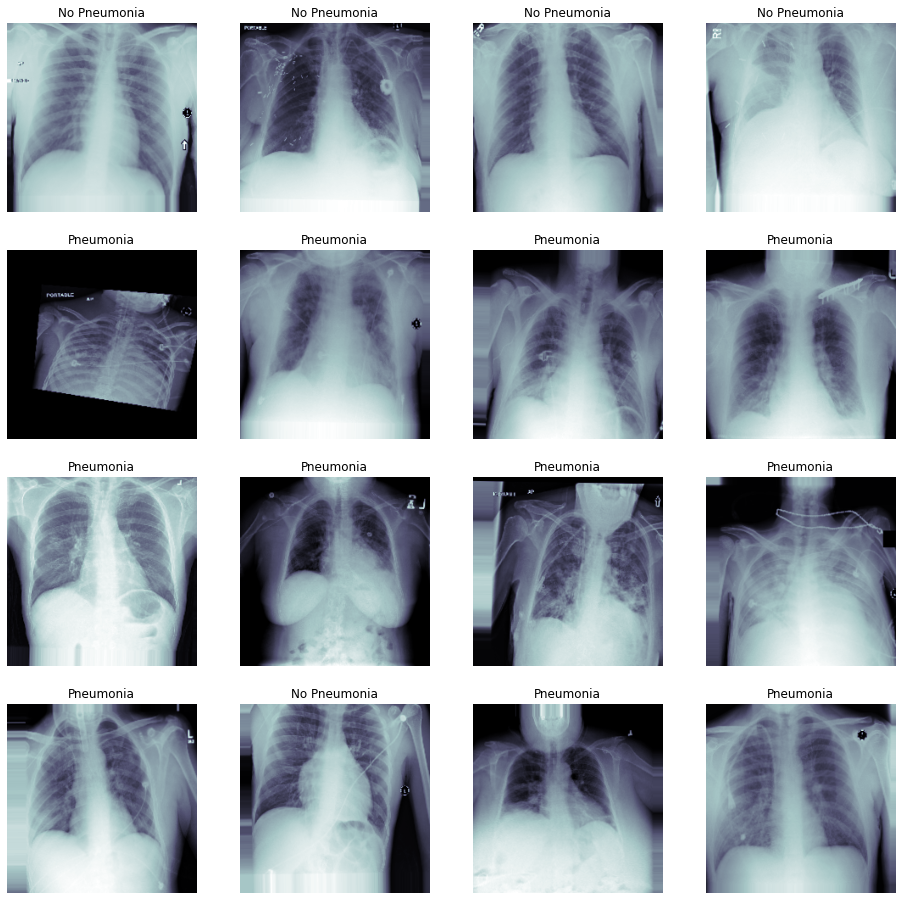

In [10]:
# Initializing training generator
train_idg = image_generator_train()
train_gen = get_generator_train(train_idg, train_df)


# Looking at some examples of our training data to understand the extent to which data is being augumented prior to training
train_x, train_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))

for (image, label, plot) in zip(train_x, train_y, m_axs.flatten()):
    plot.imshow(image[:,:,0], cmap = 'bone')
    if label == 1: 
        plot.set_title('Pneumonia')
    else:
        plot.set_title('No Pneumonia')
    plot.axis('off')

In [30]:
# Accessing the order of the classes in training generator
train_gen.class_indices

{'Negative': 0, 'Positive': 1}

In [11]:
# Initializing validation and test generators
valid_gen, test_gen = get_test_valid_generator()

Found 2140 validated image filenames belonging to 2 classes.
Found 174 validated image filenames belonging to 2 classes.
Found 1370 validated image filenames belonging to 2 classes.


## Training models based on DenseNet121:

### Model 1 

In [4]:
# Model 1: 
## transfer layer: conv5_block16_1_conv (idx 420)
## learning rate E-4
## dropout 0.2
model_1_pretrained = load_pretrained_model(pretrained_model=DenseNet121)
model_1 = build_model(model_1_pretrained, dropout=0.2)

33193984/33188688 [==============================] - 1s 0us/step
Pre-trained model layers and their trainability
input_1 False
zero_padding2d_1 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_2 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv

In [11]:
save_model(model_1, 'model_1')

Saved model architecture under model_1.json


Epoch 1/100
34/34 [==============================] - 61s 2s/step - loss: 0.6867 - binary_accuracy: 0.6112 - val_loss: 0.6805 - val_binary_accuracy: 0.5172

Epoch 00001: val_loss improved from inf to 0.68054, saving model to model_1.best.hdf5
Epoch 2/100
34/34 [==============================] - 59s 2s/step - loss: 0.6733 - binary_accuracy: 0.6243 - val_loss: 0.6664 - val_binary_accuracy: 0.5575

Epoch 00002: val_loss improved from 0.68054 to 0.66641, saving model to model_1.best.hdf5
Epoch 3/100
34/34 [==============================] - 60s 2s/step - loss: 0.6518 - binary_accuracy: 0.6463 - val_loss: 0.6448 - val_binary_accuracy: 0.6494

Epoch 00003: val_loss improved from 0.66641 to 0.64481, saving model to model_1.best.hdf5
Epoch 4/100
34/34 [==============================] - 63s 2s/step - loss: 0.6349 - binary_accuracy: 0.6584 - val_loss: 0.6287 - val_binary_accuracy: 0.6322

Epoch 00004: val_loss improved from 0.64481 to 0.62870, saving model to model_1.best.hdf5
Epoch 5/100
34/34 [=

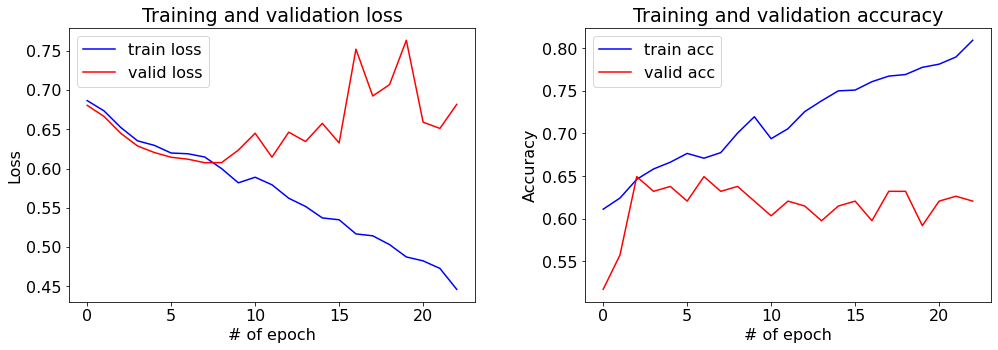

In [22]:
model_1_hist = train_model(model_1, 'model_1', train_gen, valid_gen, epochs=100)

22/21 [==============================] - 22s 1s/step


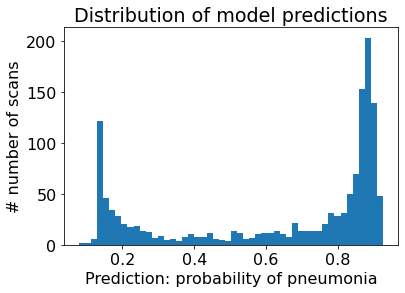

Model prediction min: 0.0785
Model prediction max: 0.926


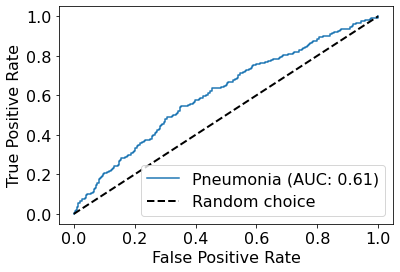

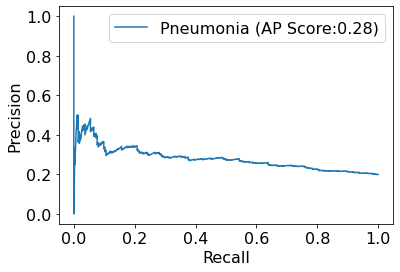

In [24]:
pred_Y_1, ground_truth_1, evaluation_dic_1 = predict_and_evaluate_model(model_1, "model_1", test_gen, steps=len(test_df)/64)

- After 8th epoch the validation loss started to increase, while the training loss continued to increase suggesting overfitting.
- The validation accuracy started to decrease after 3rd epoch confirming overfitting (best model weights were saved after 5th epoch).
- The prediction distibution is wide and exhibits two peaks, each for one class. The peak near 1.0, i.e. pneumonia positive class, has more counts, then the peak near 0.0, i.e pneumonia negative class. In contrast the test set comprises of 20% of positive pneumonia cases.
- The AUC amounts to 0.61. 


In the next model the dropout will be increased to 0.5 to avoid overfitting.

### Model 2 

In [25]:
# The same as model 1 with increased dropout 

# Model 2: 
## transfer layer: conv5_block16_1_conv (idx 420)
## learning rate E-4
## dropout 0.5

model_2_pretrained = load_pretrained_model(pretrained_model=DenseNet121)
model_2 = build_model(model_2_pretrained, dropout=0.5)
save_model(model_2, 'model_2')

Pre-trained model layers and their trainability
input_2 False
zero_padding2d_3 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_4 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu

Epoch 1/100
34/34 [==============================] - 62s 2s/step - loss: 0.6931 - binary_accuracy: 0.4995 - val_loss: 0.6930 - val_binary_accuracy: 0.5172

Epoch 00001: val_loss improved from inf to 0.69304, saving model to model_2.best.hdf5
Epoch 2/100
34/34 [==============================] - 51s 1s/step - loss: 0.6930 - binary_accuracy: 0.5308 - val_loss: 0.6927 - val_binary_accuracy: 0.5287

Epoch 00002: val_loss improved from 0.69304 to 0.69271, saving model to model_2.best.hdf5
Epoch 3/100
34/34 [==============================] - 54s 2s/step - loss: 0.6926 - binary_accuracy: 0.5491 - val_loss: 0.6921 - val_binary_accuracy: 0.5460

Epoch 00003: val_loss improved from 0.69271 to 0.69207, saving model to model_2.best.hdf5
Epoch 4/100
34/34 [==============================] - 54s 2s/step - loss: 0.6916 - binary_accuracy: 0.5720 - val_loss: 0.6928 - val_binary_accuracy: 0.5345

Epoch 00004: val_loss did not improve from 0.69207
Epoch 5/100
34/34 [==============================] - 56s 2s

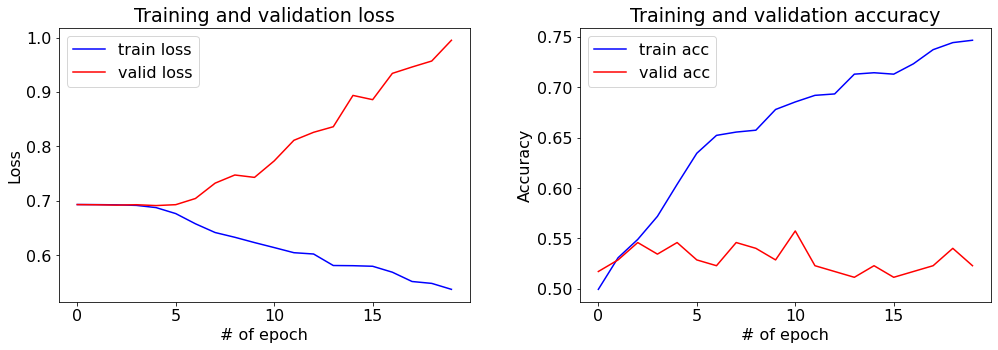

In [26]:
model_2_hist = train_model(model_2, 'model_2', train_gen, valid_gen, epochs=100)

22/21 [==============================] - 22s 1s/step


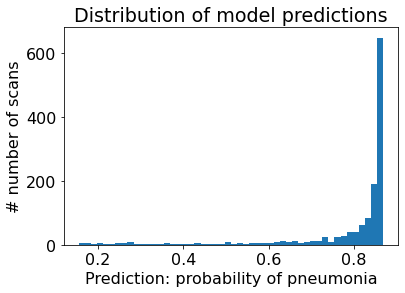

Model prediction min: 0.155
Model prediction max: 0.868


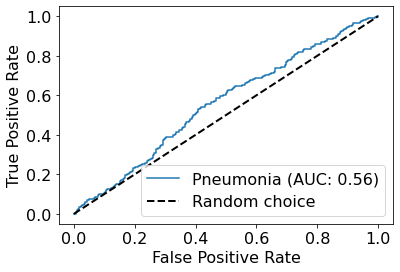

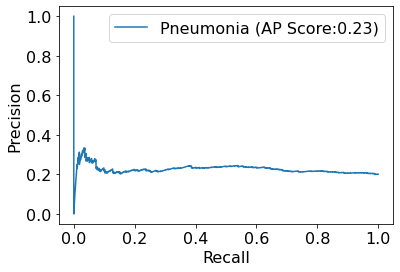

In [27]:
pred_Y_2, ground_truth_2, evaluation_dic_2 = predict_and_evaluate_model(model_2, "model_2", test_gen, steps=len(test_df)/64)

- After 5th epoch the validation loss started to increase, while the training loss continued to increase suggesting overfitting.
- The validation accuracy started to decrease after 3rd epoch confirming overfitting (best model weights were saved after 5th epoch).
- The prediction distibution exhibits single peak near 1.0, i.e. pneumonia positive class, meaning that most of the scans are predicted as pneumonia positve.

The next model will be based on model 1 with increased starting learnig rate, as smaller learning rate ranges increase the risk of stucking in local minimum resulting in lack of improvement in validation accuracy.




### Model 3

In [11]:
# The same as model 1 with increased learning rate 

# Model 3: 
## transfer layer: conv5_block16_1_conv (idx 420)
## learning rate E-3
## dropout 0.2

model_3_pretrained = load_pretrained_model(pretrained_model=DenseNet121)
model_3 = build_model(model_3_pretrained, lr=0.01, dropout=0.2)
save_model(model_3, 'model_3')

Pre-trained model layers and their trainability
input_2 False
zero_padding2d_3 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_4 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu

Epoch 1/100
34/34 [==============================] - 60s 2s/step - loss: 0.6840 - binary_accuracy: 0.5710 - val_loss: 0.6795 - val_binary_accuracy: 0.5172

Epoch 00001: val_loss improved from inf to 0.67955, saving model to model_3.best.hdf5
Epoch 2/100
34/34 [==============================] - 51s 1s/step - loss: 0.6876 - binary_accuracy: 0.5963 - val_loss: 0.6842 - val_binary_accuracy: 0.6092

Epoch 00002: val_loss did not improve from 0.67955
Epoch 3/100
34/34 [==============================] - 54s 2s/step - loss: 0.6706 - binary_accuracy: 0.6196 - val_loss: 0.6546 - val_binary_accuracy: 0.6322

Epoch 00003: val_loss improved from 0.67955 to 0.65459, saving model to model_3.best.hdf5
Epoch 4/100
34/34 [==============================] - 53s 2s/step - loss: 0.6547 - binary_accuracy: 0.6336 - val_loss: 0.6985 - val_binary_accuracy: 0.4943

Epoch 00004: val_loss did not improve from 0.65459
Epoch 5/100
34/34 [==============================] - 53s 2s/step - loss: 0.6588 - binary_accuracy:

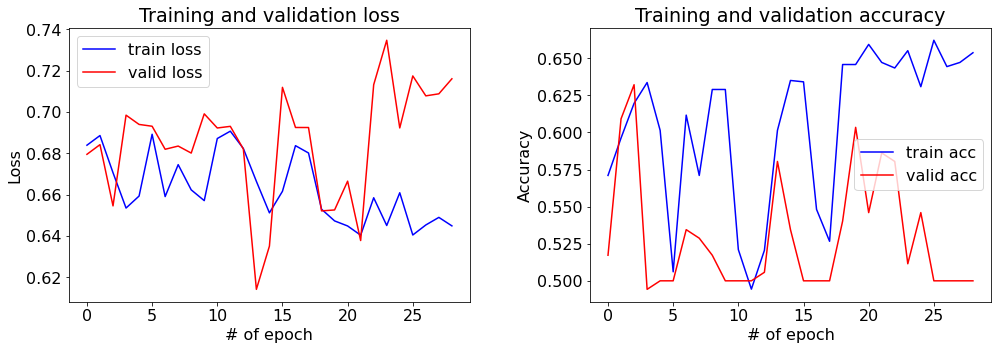

In [29]:
model_3_hist = train_model(model_3, 'model_3', train_gen, valid_gen, epochs=100)

22/21 [==============================] - 22s 1s/step


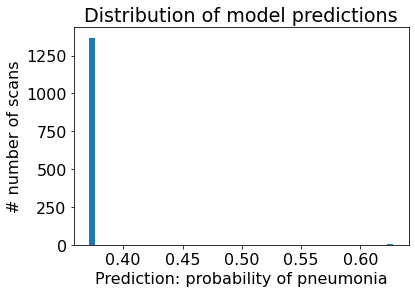

Model prediction min: 0.371
Model prediction max: 0.628


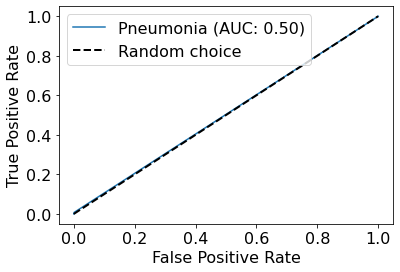

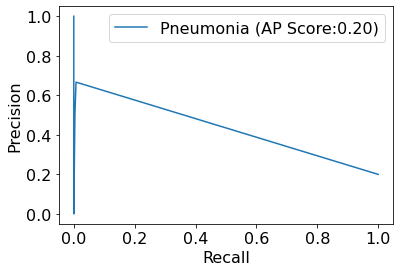

In [30]:
pred_Y_3, ground_truth_3, evaluation_dic_3 = predict_and_evaluate_model(model_3, "model_3", test_gen, steps=len(test_df)/64)

- The training and validation loss did not decrease, while the accuracies did not increase during training, meaning that the model did not learn. Those signals are very noisy, suggesting that the learning rate ranges are too high and thus overshooting minimum/local minima.

- The AUC amounts to 0.5, a value equal to random choice.

The next model will be based on model 1 with more layers frozen to avoid overfitting.


### Model 4 

In [36]:
# The same as model 1 with more layers frozen 

# Model 4: 
## transfer layer: avg_pool (idx 427)
## learning rate E-4
## dropout 0.2
model_4_pretrained = load_pretrained_model(pretrained_model=DenseNet121, transfer_layer='avg_pool', 
                          transfer_layer_idx=427)
model_4 = build_model(model_4_pretrained, dropout=0.2)
save_model(model_4, 'model_4')

Pre-trained model layers and their trainability
input_8 False
zero_padding2d_15 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_16 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_re

Epoch 1/50
34/34 [==============================] - 60s 2s/step - loss: 0.6931 - binary_accuracy: 0.5164 - val_loss: 0.6933 - val_binary_accuracy: 0.5517

Epoch 00001: val_loss improved from inf to 0.69332, saving model to model_4.best.hdf5
Epoch 2/50
34/34 [==============================] - 49s 1s/step - loss: 0.6926 - binary_accuracy: 0.5645 - val_loss: 0.6926 - val_binary_accuracy: 0.5862

Epoch 00002: val_loss improved from 0.69332 to 0.69262, saving model to model_4.best.hdf5
Epoch 3/50
34/34 [==============================] - 52s 2s/step - loss: 0.6912 - binary_accuracy: 0.5935 - val_loss: 0.6894 - val_binary_accuracy: 0.5747

Epoch 00003: val_loss improved from 0.69262 to 0.68940, saving model to model_4.best.hdf5
Epoch 4/50
34/34 [==============================] - 53s 2s/step - loss: 0.6883 - binary_accuracy: 0.6126 - val_loss: 0.6838 - val_binary_accuracy: 0.6149

Epoch 00004: val_loss improved from 0.68940 to 0.68385, saving model to model_4.best.hdf5
Epoch 5/50
34/34 [======

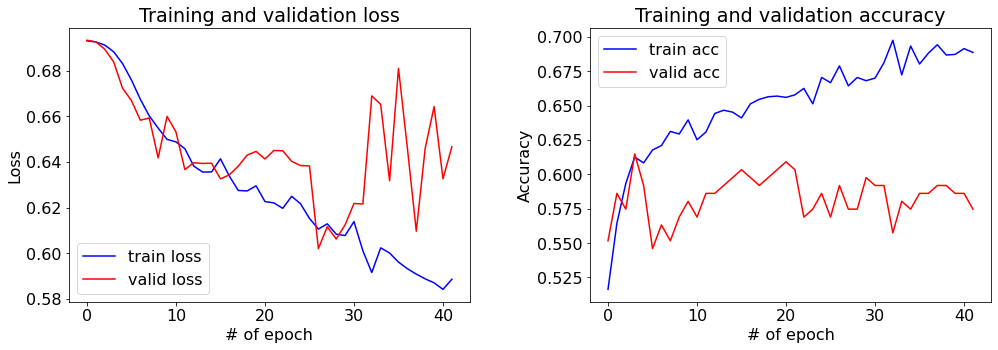

In [37]:
model_4_hist = train_model(model_4, 'model_4', train_gen, valid_gen, epochs=50)

22/21 [==============================] - 23s 1s/step


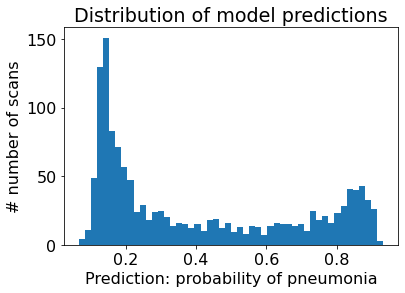

Model prediction min: 0.0671
Model prediction max: 0.932


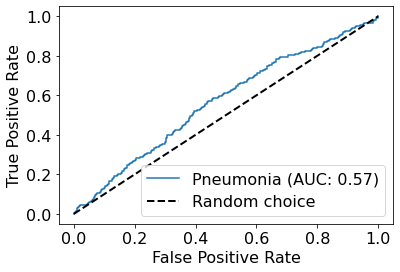

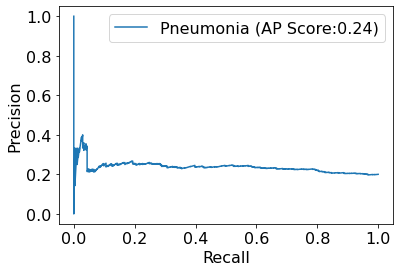

In [38]:
pred_Y_4, ground_truth_4, evaluation_dic_4 = predict_and_evaluate_model(model_4, "model_4", test_gen, steps=len(test_df)/64)

- The validation loss was decreasing at till circa 15 epoch, afterwards it was very noisy. The validation accuracy was increasing until 5th epoch, afterwards it was very noisy and lower than training accuracy (best model weights were saved after 27th epoch).
- The prediction distibution is wide and exhibits two peaks, each for one class. The peak near 1.0, i.e. pneumonia positive class, has less counts, then the peak near 0.0, i.e pneumonia negative class, in agreement with the test set comprising of 20% of positive pneumonia cases.
- The AUC amounts to 0.57. 

In the next model only prediction layer will be attached to the pretrained model, to decrease its complexity and thus avoiding overfitting.

### Model 5

In [12]:
# The same as model 4 with only prediction layer attached to the pretrained model

# Model 5: 
## transfer layer: avg_pool (idx 427)
## learning rate E-4

model_5_pretrained = load_pretrained_model(pretrained_model=DenseNet121, transfer_layer='avg_pool', 
                          transfer_layer_idx=427)
model_5 = build_simpler_model(model_5_pretrained)
save_model(model_5, 'model_5')

Pre-trained model layers and their trainability
input_1 False
zero_padding2d_1 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_2 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu

Epoch 1/100
34/34 [==============================] - 65s 2s/step - loss: 0.6930 - binary_accuracy: 0.5248 - val_loss: 0.6926 - val_binary_accuracy: 0.5632

Epoch 00001: val_loss improved from inf to 0.69265, saving model to model_5.best.hdf5
Epoch 2/100
34/34 [==============================] - 49s 1s/step - loss: 0.6925 - binary_accuracy: 0.5636 - val_loss: 0.6922 - val_binary_accuracy: 0.5402

Epoch 00002: val_loss improved from 0.69265 to 0.69215, saving model to model_5.best.hdf5
Epoch 3/100
34/34 [==============================] - 54s 2s/step - loss: 0.6918 - binary_accuracy: 0.5935 - val_loss: 0.6919 - val_binary_accuracy: 0.5230

Epoch 00003: val_loss improved from 0.69215 to 0.69186, saving model to model_5.best.hdf5
Epoch 4/100
34/34 [==============================] - 50s 1s/step - loss: 0.6908 - binary_accuracy: 0.5893 - val_loss: 0.6918 - val_binary_accuracy: 0.5517

Epoch 00004: val_loss improved from 0.69186 to 0.69176, saving model to model_5.best.hdf5
Epoch 5/100
34/34 [=

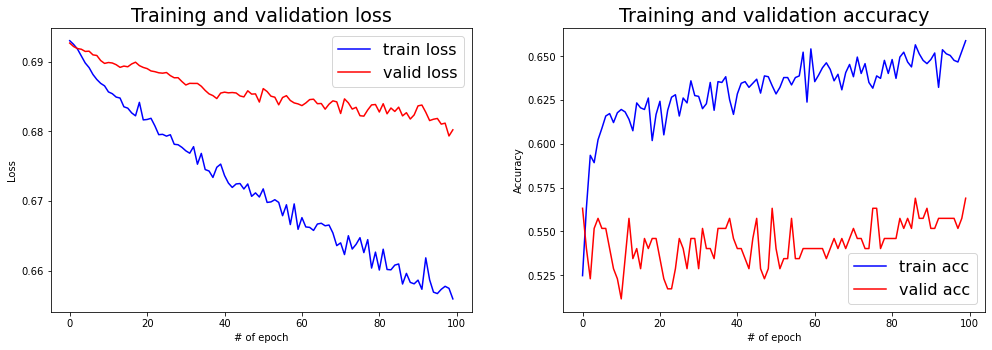

In [13]:
model_5_hist = train_model(model_5, 'model_5', train_gen, valid_gen, epochs=100)

22/21 [==============================] - 23s 1s/step


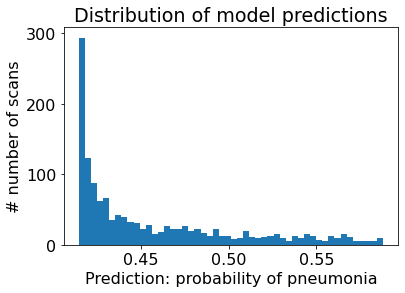

Model prediction min: 0.415
Model prediction max: 0.588


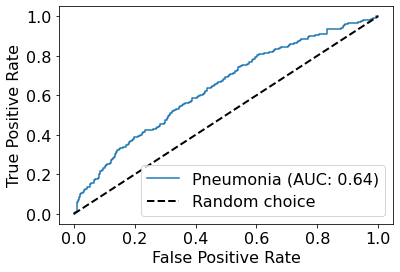

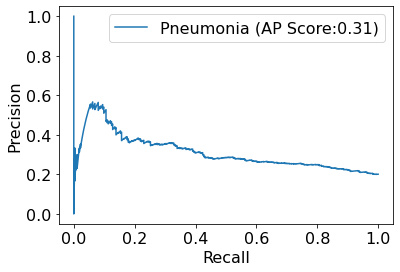

In [14]:
pred_Y_5, ground_truth_5, evaluation_dic_5 = predict_and_evaluate_model(model_5, "model_5", test_gen, steps=len(test_df)/64)

- The training and validation losses (accuracies) were  decreasing (increasing) verly slowly during the training, indicating very slow learning.
- The prediction distribution exhibits single peak for the pneumonia negative class.

The starting learning rate will be increased in the next model.

### Model 6

In [15]:
# The same as model 5 with increased learning rate

# Model 5: 
## transfer layer: avg_pool (idx 427)
## learning rate E-3

model_6_pretrained = load_pretrained_model(pretrained_model=DenseNet121, transfer_layer='avg_pool', 
                          transfer_layer_idx=427)
model_6 = build_simpler_model(model_6_pretrained, lr=0.001)
save_model(model_6, 'model_6')

Pre-trained model layers and their trainability
input_2 False
zero_padding2d_3 False
conv1/conv False
conv1/bn False
conv1/relu False
zero_padding2d_4 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu

Epoch 1/60
34/34 [==============================] - 60s 2s/step - loss: 0.6908 - binary_accuracy: 0.5621 - val_loss: 0.6897 - val_binary_accuracy: 0.5747

Epoch 00001: val_loss improved from inf to 0.68970, saving model to model_6.best.hdf5
Epoch 2/60
34/34 [==============================] - 49s 1s/step - loss: 0.6860 - binary_accuracy: 0.6005 - val_loss: 0.6869 - val_binary_accuracy: 0.5747

Epoch 00002: val_loss improved from 0.68970 to 0.68691, saving model to model_6.best.hdf5
Epoch 3/60
34/34 [==============================] - 56s 2s/step - loss: 0.6827 - binary_accuracy: 0.6126 - val_loss: 0.6832 - val_binary_accuracy: 0.5632

Epoch 00003: val_loss improved from 0.68691 to 0.68321, saving model to model_6.best.hdf5
Epoch 4/60
34/34 [==============================] - 55s 2s/step - loss: 0.6794 - binary_accuracy: 0.6112 - val_loss: 0.6858 - val_binary_accuracy: 0.5230

Epoch 00004: val_loss did not improve from 0.68321
Epoch 5/60
34/34 [==============================] - 55s 2s/step

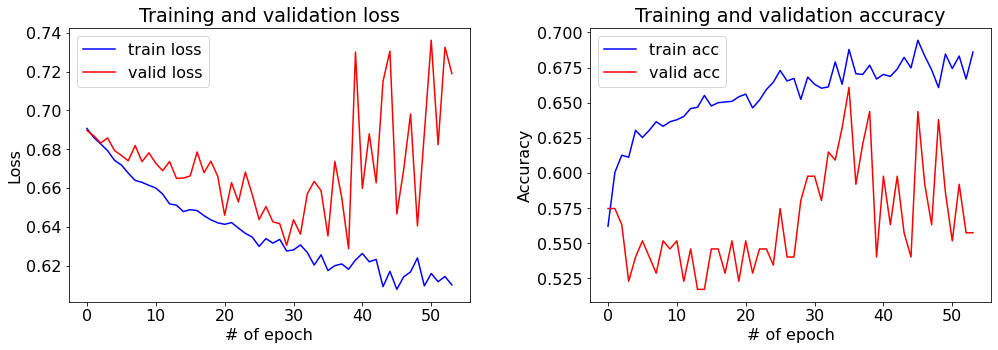

In [16]:
model_6_hist = train_model(model_6, 'model_6', train_gen, valid_gen, epochs=60)

22/21 [==============================] - 22s 998ms/step


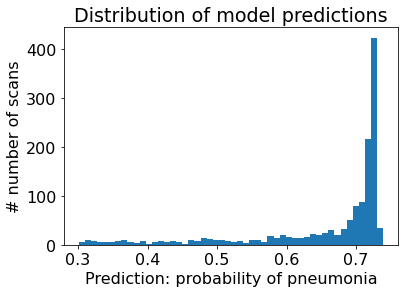

Model prediction min: 0.301
Model prediction max: 0.739


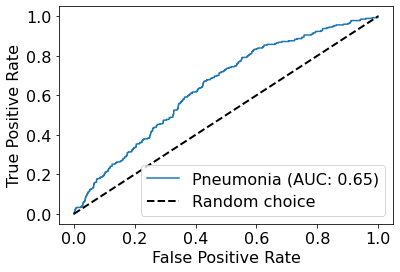

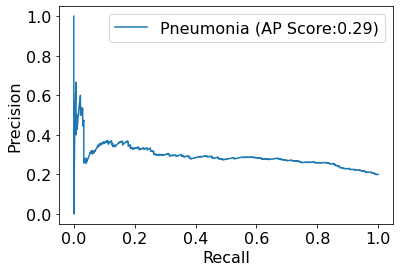

In [17]:
pred_Y_6, ground_truth_6, evaluation_dic_6 = predict_and_evaluate_model(model_6, "model_6", test_gen, steps=len(test_df)/64)

- The validation loss (accuracy) did not improve during the training..
- The prediction distribution exhibits single peak for the pneumonia positive class.

## Model performance summary

In [2]:
data = {'Model': ['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 'Model_6'],
       'Transfer layer': ['conv5_block16_1_conv', 'conv5_block16_1_conv', 'conv5_block16_1_conv', 
                          'avg_pool', 'avg_pool', 'avg_pool'],
       'Transfer layer idx': [420, 420, 420, 427, 427, 427],
       'Embedding model': ['standard', 'standard', 'standard', 'standard', 'simpler', 'simpler'],
       'Starting learning rate' : ['E-4', 'E-4', 'E-3', 'E-4', 'E-4', 'E-3'],
       'Dropout': [0.2, 0.5, 0.2, 0.2, 0.0, 0.0],
       'Best Epoch /Epochs set)' : ['5/100', '5/100', '14/100', '27/50', '100/100', '39/60'],
       'Prediction distribution': ['0.08 - 0.93', '0.16 - 0.87', '0.37 - 0.63', '0.07 - 0.93', '0.42 - 0.59', '0.30 - 0.74'],
       'Prediction distribution: peaks': ['Two (wrong ratio)', 'Single', 'Single', 
                                          'Two (ratio closer to 80/20)', 'Single', 'Single'],
       'AUC' : [0.61, 0.56, 0.50, 0.57, 0.64, 0.65],
       'AP Score' : [0.28, 0.23, 0.20, 0.24, 0.31, 0.29],
       'Comment' : ['Highly overfitting  after first epochs', 'Highly overfitting', 'Underfitting', 
                    'Overfitting', 'Slow learning', 'No learning']}
models_summary = pd.DataFrame(data=data)
models_summary

,Model,Transfer layer,Transfer layer idx,Embedding model,Starting learning rate,Dropout,Best Epoch /Epochs set),Prediction distribution,Prediction distribution: peaks,AUC,AP Score,Comment
0,Model_1,conv5_block16_1_conv,420,standard,E-4,0.2,5/100,0.08 - 0.93,Two (wrong ratio),0.61,0.28,Highly overfitting after first epochs
1,Model_2,conv5_block16_1_conv,420,standard,E-4,0.5,5/100,0.16 - 0.87,Single,0.56,0.23,Highly overfitting
2,Model_3,conv5_block16_1_conv,420,standard,E-3,0.2,14/100,0.37 - 0.63,Single,0.50,0.20,Underfitting
3,Model_4,avg_pool,427,standard,E-4,0.2,27/50,0.07 - 0.93,Two (ratio closer to 80/20),0.57,0.24,Overfitting
4,Model_5,avg_pool,427,simpler,E-4,0.0,100/100,0.42 - 0.59,Single,0.64,0.31,Slow learning
5,Model_6,avg_pool,427,simpler,E-3,0.0,39/60,0.30 - 0.74,Single,0.65,0.29,No learning


## Next steps

Hyperparameter tuning of model 4:  
- higher dropout, i.e. 0.5
- freezing avg_pooling layer and retraining the last dense layer together with layers attached after the pre-trained model.
- introducing regularization for the layers attached after the pre-trained model.
- changing batch size